In [82]:
from sklearn.experimental import enable_iterative_imputer

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score

import xgboost as xgb

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import copy
import time

In [2]:
d_tr = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/Titanic/train.csv', index_col='PassengerId')
d_te = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/Titanic/test.csv', index_col=0)

In [3]:
X = d_tr.drop(columns='Survived').copy()
# label = LabelEncoder()
y = LabelEncoder().fit_transform(d_tr.Survived.copy())#.astype('int') #To avoid getting an error that 'y' is unknown

> __Cleaning__ and encoding __X__ precerving **nan**

In [7]:
X = preprocesor.fit_transform(X)
X.shape

(891, 12)

> __Train Test Split__

In [261]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, test_size=0.20)

# == -- GradientBoostingClassifier --==

In [23]:
model = GradientBoostingClassifier()

# imputer = KNNImputer()
imputer = IterativeImputer(max_iter=20) #default is 10 iteractions

param_grid = [{ #regular grid search took about 1 ahour with KNNImputer
            'model__n_estimators': [10, 100, 1000],
            'model__learning_rate': [0.001, 0.01, 0.1],
            'model__subsample': [0.5, 0.7, 1.0],
            'model__max_depth': [3, 7, 9],
    
            'impute__imputation_order': ['ascending', 'descending', 'roman', 'arabic', 'random']
#             'impute__n_neighbors': [1,2,3,5,7,11,13,17,19]
              }]

In [24]:
classifier = Pipeline([
                       ('impute', imputer),
                       ('model', model)
                      ])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

gs = GridSearchCV(classifier, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=1)

# rs = RandomizedSearchCV(classifier, param_distributions=param_grid, cv=cv, n_jobs=-1, 
#                         scoring='accuracy', n_iter=50, verbose=1)


In [25]:
gs.fit(X_tr, y_tr)

Fitting 30 folds for each of 405 candidates, totalling 12150 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
             estimator=Pipeline(steps=[('impute',
                                        IterativeImputer(max_iter=20)),
                                       ('model',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid=[{'impute__imputation_order': ['ascending',
                                                       'descending', 'roman',
                                                       'arabic', 'random'],
                          'model__learning_rate': [0.001, 0.01, 0.1],
                          'model__max_depth': [3, 7, 9],
                          'model__n_estimators': [10, 100, 1000],
                          'model__subsample': [0.5, 0.7, 1.0]}],
             scoring='accuracy', verbose=1)

### KNN

In [22]:
# GridSearch 21870 fit about 80 minutes
print('Training score: {:.4f}'.format(gs.best_score_))
print('Test score    : {:.4f}'.format(accuracy_score(y_te, gs.predict(X_te))))
gs.best_params_

Training score: 0.8119
Test score    : 0.7762


{'impute__n_neighbors': 1,
 'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 1000,
 'model__subsample': 1.0}

### Iteractive

In [26]:
# around 50 minutes and get the same result of RandomizedSearchCV= n_iter=50 (20 minutes)
# GridSearch 12150 fit
print('Training score: {:.4f}'.format(gs.best_score_))
print('Test score    : {:.4f}'.format(accuracy_score(y_te, gs.predict(X_te))))
gs.best_params_

Training score: 0.8093
Test score    : 0.7832


{'impute__imputation_order': 'ascending',
 'model__learning_rate': 0.01,
 'model__max_depth': 9,
 'model__n_estimators': 1000,
 'model__subsample': 0.7}

# === -- XGBOOST -- ==

> RandomizedSearchCV

In [178]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_grid = [{ #4*7*5*5*7*(cv=7)=34,300
               'model__n_estimators': [503, 599, 673, 761, 857, 947, 1013], 
               'model__eta': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006],
               'model__max_depth': [1, 3, 5, 7, 11], 
               'model__subsample': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], 
               'model__colsample_bytree': [0.2, 0.3, 0.4, 0.5], 
#                'model__colsample_bylevel': [0.4, 0.5, 0.6], 
#                'model__colsample_bynode':[0.4, 0.5, 0.6],
               }]

classifier = Pipeline([
#                        ('impute', imputer),
                       ('model', model)
                      ])

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=1)

# gs = GridSearchCV(classifier, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='neg_log_loss', verbose=1)

rs = RandomizedSearchCV(classifier, param_distributions=param_grid, cv=cv, 
                         n_iter=750, scoring='neg_log_loss', verbose=1) #n_iter = cuantos modelos va a usar

### =====---- Runing
t0 = time.time()
rs.fit(X_tr, y_tr)
t1 = time.time()

Fitting 7 folds for each of 750 candidates, totalling 5250 fits


# Scores DataFrame

In [189]:
best_params = rs.best_params_.copy()

best_params.update({'best_score_':rs.best_score_, 
                    'n_iter':rs.n_iter, 
                    'total_fits':5250, 
                    'fit_time': (t1-t0)/60 
                   })

# best_params = {'model__subsample': 0.7, 
#                'model__n_estimators': 857, 
#                'model__max_depth': 11, 
#                'model__eta': 0.01, 
#                'model__colsample_bytree': 0.4
#               }

# best_params.update({'best_score_':-0.438863, 
#                     'n_iter':1500, 
#                     'total_fits':10500, 
#                     'fit_time': 50.666010 
#                    })

# #first time to make a DataFrame
# values = pd.DataFrame.from_dict([best_params.copy()])

# to add new score to a DataFrame
temp_df = pd.DataFrame.from_dict([best_params])
values = pd.concat([values, temp_df], axis=0, join='outer', ignore_index=True)

values

,model__subsample,model__n_estimators,model__max_depth,model__eta,model__colsample_bytree,best_score_,n_iter,total_fits,fit_time
0,0.7,857,11,0.010,0.4,-0.438863,1500,10500,50.666010
1,0.8,1013,11,0.006,0.4,-0.447921,750,5250,25.605574


In [387]:
values.to_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/Titanic/scores_grid_search.csv')

In [175]:
print(10500)
print((t1-t0)/60)
print(rs.best_score_)
print(rs.best_params_)

10500
50.66601836284001
-0.43886318016128534
{'model__subsample': 0.7, 'model__n_estimators': 857, 'model__max_depth': 11, 'model__eta': 0.01, 'model__colsample_bytree': 0.4}


In [150]:
print(5250)
print((t1-t0)/60)
print(rs.best_score_)
print(rs.best_params_)

5250
25.829232732454937
-0.45134778023857136
{'model__subsample': 0.8, 'model__n_estimators': 761, 'model__max_depth': 11, 'model__eta': 0.01, 'model__colsample_bytree': 0.3}


> Manually

In [381]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, test_size=0.20)
evalset = [(X_tr, y_tr), (X_te,y_te)]

In [382]:

params = {'eval_metric':'logloss', 
          'use_label_encoder':False, 
          'n_estimators':821, #1013
          'eta':0.006, #0.004
          'max_depth':11, #11
          'subsample':0.8,#0.8         # ratio of the training instance
          'colsample_bytree':0.4,  # ratio of columns when constructing each tree
#           'colsample_bylevel':0.6, # ratio of columns for each level
#           'colsample_bynode':0.4   # ratio of columns for each split
          'gamma':0,
          'min_child_weight':(3/342)}

model = xgb.XGBClassifier(**params)

In [383]:
t0 = time.time()

model.fit(X_tr, y_tr, 
          eval_set=evalset, 
          eval_metric='logloss',
          verbose=False
         )

t1 = time.time()

# Testing

In [385]:
test_accuracy = accuracy_score(y_te, model.predict(X_te))
print('time training   : {}'.format(t1-t0))
print('test accuracy   : {}'.format(test_accuracy))

time training   : 1.0531229972839355
test accuracy   : 0.8379888268156425


In [386]:
params.update({'test_accuracy':test_accuracy})

# #first time to make a DataFrame
best_params = pd.DataFrame.from_dict([params.copy()])

# to add new score to a DataFrame
# temp_df = pd.DataFrame.from_dict([params])
# best_xgb = pd.concat([best_xgb, temp_df], axis=0, join='outer', ignore_index=True)

best_params
# best_params.to_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/Titanic/best_xgb_model.csv')

,eval_metric,use_label_encoder,n_estimators,eta,max_depth,subsample,colsample_bytree,gamma,min_child_weight,test_accuracy
0,logloss,False,821,0.006,11,0.8,0.4,0,0.008772,0.837989


In [388]:
best_params.to_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/Titanic/best_xgb_model.csv')

# submition March 17 2022

In [391]:
best_params

,eval_metric,use_label_encoder,n_estimators,eta,max_depth,subsample,colsample_bytree,gamma,min_child_weight,test_accuracy
0,logloss,False,821,0.006,11,0.8,0.4,0,0.008772,0.837989


In [390]:
data_test = preprocesor.fit_transform(d_te)

model.fit(X, y)

y_hat = model.predict(data_test)
submition = pd.DataFrame({'PassengerId' : d_te.index.to_list(), 'Survived' : y_hat})
submition.to_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/Titanic/submition.csv', index=False)

> cross value score

In [366]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
tr_score = cross_val_score(model, X_tr, y_tr, cv=cv, scoring='neg_log_loss', verbose=1)

print('training score: {}'.format(np.mean(tr_score)))

# gs = GridSearchCV(classifier, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='neg_log_loss', verbose=1)

# rs = RandomizedSearchCV(classifier, param_distributions=param_grid, cv=cv, 
#                         n_jobs=-1, n_iter=1039, scoring='neg_log_loss', verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


training score: -0.45794745901428036


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   15.4s finished


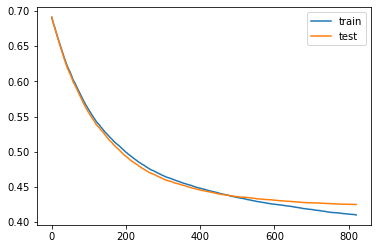

In [365]:
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

# Best 2 result

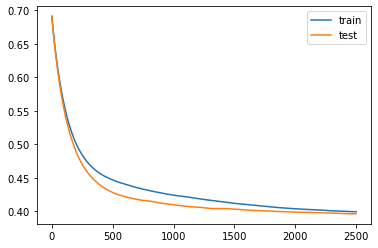

In [59]:
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

#======. Model that gave the results

# model = xgb.XGBClassifier(use_label_encoder=False, 
#                           n_estimators=2500, 
#                           eta=0.005,
#                           max_depth=3
#                          )

In [54]:
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.005, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.00499999989,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=2500, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


In [ ]:
base_score=0.5, 
booster='gbtree', 
subsample=1,
colsample_bylevel=1,
colsample_bynode=1, 
colsample_bytree=1, 
enable_categorical=False,
max_depth=6, 
n_jobs=8,
eta=0.005, 
n_estimators=2500, 
gamma=0, 
gpu_id=-1, 
importance_type=None,
interaction_constraints='', 
learning_rate=0.00499999989,
max_delta_step=0, 
min_child_weight=1, 
missing=nan,
monotone_constraints='()', 
num_parallel_tree=1, 
predictor='auto', 
random_state=0,
reg_alpha=0, 
reg_lambda=1, 
scale_pos_weight=1, 
tree_method='exact', 
use_label_encoder=False,
validate_parameters=1, 
verbosity=None

# == -- RandomForestClassifier -- ==

In [ ]:
model = RandomForestClassifier(n_jobs=-1)

# imputer = KNNImputer()
imputer = IterativeImputer(max_iter=20) #default is 10 iteractions

param_grid = [{ # 216 iter in a regular grid search
                'model__criterion' : ["gini", "entropy"],
                'model__n_estimators': [10, 100, 1000],
                'model__max_features': ['sqrt', 'log2'],
                'model__class_weight' : [ None, "balanced", "balanced_subsample"],
    
            'impute__imputation_order': ['ascending', 'descending', 'roman', 'arabic', 'random']
#             'impute__n_neighbors': [1,2,3,5,7,11,13,17,19]
               }] 

> __Custom Functions__

In [4]:
def isCabinNan(df):
    ''' Recive a data frame'''
           
    df = copy.deepcopy(df)
    
    s = pd.DataFrame(df['Cabin'].notnull().astype('int'), columns=['Cabin'])
    
    return s

def encodeFare(df):
    ''' '''
    
    s = copy.deepcopy(df)
    
    s[ (s <= 7.91) ] = 0
    s[(s > 7.91) & (s <= 14.454)] = 1
    s[(s > 14.454) & (s <= 31)]   = 2
    s[ (s > 31) ] = 3
    
    return s

def encodeAge(df):                       
    ''' Recive a pd Data Frame '''        
                                        
    
    s = copy.deepcopy(df)
    
    s.loc[(s.Age <= 13), 'Age'] = 1
    s.loc[(s.Age > 13) & (s.Age <= 18), 'Age'] = 2
    s.loc[(s.Age > 18) & (s.Age <= 30), 'Age'] = 3
    s.loc[(s.Age > 30) & (s.Age <= 50), 'Age'] = 4
    s.loc[(s.Age > 50), 'Age'] = 5
    
#     s[(s <= 13)] = 1
#     s[(s > 13) & (s <= 18)] = 2
#     s[(s > 18) & (s <= 30)] = 3
#     s[(s > 30) & (s <= 50)] = 4
#     s[(s > 50)] = 5
    
    return s

def familySize(df):
    ''' Recive a data frama'''
    
    s = np.zeros( (len(df.index), 1) )
    
    # if overall members family are equeal to 1 mean they ar alone
    s[ ( (df['SibSp'] +  df['Parch'] + 1) == 1 ) ] = 1
    
    return s

def getTitles(df):
    ''' Recive a data frame'''
    
    s = copy.deepcopy(df)
    
    s['Title'] = s['Name'].str.extract(' ([A-Za-z]+)\.')
    s['Title'] = s['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',                                       
                                    'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    s['Title'] = s['Title'].replace(['Mlle', 'Ms'], 'Miss')
    s['Title'] = s['Title'].replace(['Mme'], 'Mrs')
    
#     resulting titles = 'Mr', 'Miss', 'Mrs', 'Master', 'Other'
    
    s = s.drop(columns='Name').copy()
    
    return s
    
def encodeSex(df):
    ''' Recive a data frame'''
    
    s = copy.deepcopy(df)
    oh = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    return oh.fit_transform(s)


isCabinNan_func = FunctionTransformer(isCabinNan, validate=False)
getTitles_func = FunctionTransformer(getTitles, validate=False)
fare_func = FunctionTransformer(encodeFare, validate=False)
age_func = FunctionTransformer(encodeAge, validate=False)
familySize_func = FunctionTransformer(familySize, validate=False)
codeSex_func = FunctionTransformer(encodeSex, validate=False)



> Transformers

In [5]:
## Age
age_trans = ColumnTransformer([
                                ('age', age_func, ['Age']) 
                               ])

## Embarked
embar_trans = ColumnTransformer([             # this returns a np.array
                                  ('embarked', OrdinalEncoder(), ['Embarked'])
                                 ])

## Fare
fare_trans = ColumnTransformer([
                                ('encode', fare_func, ['Fare'])
                               ])

## 'SibSp', 'Parch' -> IsAlone
familySize_trans = ColumnTransformer([
                                      ('size', familySize_func, ['SibSp', 'Parch'])
                                     ])

## Sex
sex_trans = ColumnTransformer([
                               ('sex', OneHotEncoder(handle_unknown='ignore', sparse=False), ['Sex']) #creo puedo usar directo oneHot encoder
                              ])                              #OneHotEncoder(handle_unknown='ignore', sparse=False)

## names -> Titles
getTitles_trans = ColumnTransformer([
                                     ('titles', getTitles_func, ['Name'])
                                    ])

encodeTiles_trans = Pipeline([
                              ('title_trans', getTitles_trans), 
                              ('oh', OneHotEncoder(handle_unknown='ignore', sparse=False)) #if sparce = true
                             ])                                             # returns scipy.sparse.csr.csr_matrix

## Cabin 
isCabinNan_trans = ColumnTransformer([ 
                                      ('cabin', isCabinNan_func, ['Cabin'])
                                     ])




> Preprocesor

In [6]:
preprocesor = FeatureUnion([                                            
                            ('age_t', age_trans),        # add 1 colunm  
                            ('embarked_t', embar_trans), # add 1 colunm 
                            ('fare', fare_trans),        # add 1 colunm 
                            ('size', familySize_trans),  # add 1 colunm
                            ('sex', sex_trans),          # add 2 colunm
                            ('title', encodeTiles_trans),# add 5 colunm
                            ('cabin', isCabinNan_trans)  # add 1 colunm
                           ])

# to test diferent parts of the code

In [31]:
data = preprocesor.fit_transform(d_tr)
print(type(data))
data[814:834]

<class 'numpy.ndarray'>


array([[ 4.,  2.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.],
       [nan,  2.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.],
       [ 3.,  2.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 4.,  0.,  3.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 4.,  2.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  2.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  2.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.],
       [ 3.,  2.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 4.,  2.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 3.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.],
       [ 1.,  2.,  3.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [nan,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.],
       [nan,  2.,  3.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  3.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [nan,  1.,  0.,  1.,  0.,  

In [17]:
d_tr[d_tr.Embarked.isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN
